### How calibrations inform policy
In many practical applications of modelling, we don’t know the values of all the parameters. To determine the impact of interventions on an epidemic using mathematical modelling and to inform policy, we first need to estimate the parameter values from the available data, such as the prevalence of infection. Then, we can use the inferred parameter values to make projections about the effect of different interventions.

This exercise will show you how the least-squares approach to calibrating a model can be used in the model development process with the aim of informing policy-relevant questions.

Running the cell below will load a new dataset of the prevalence of infection for an outbreak that lasted 200 days, in a population of 500 people. We can calibrate a SIR model to this dataset using the automated least-squares algorithm, and then to use this information to draw conclusions about the amount of vaccination that will be needed, to protect other populations from this disease.




In [67]:
library(deSolve)
library(reshape2)
library(ggplot2)
library(dplyr)

In [60]:
getwd()

[1] "/Users/fyego/Downloads/fk_staff/JUPYTER R/SIR"

In [61]:
dataprov3 <- read.table("https://bit.ly/2vDqAYN", header = TRUE)
summary(dataprov3)

      day            cases       
 Min.   : 0.00   Min.   :  1.00  
 1st Qu.: 3.25   1st Qu.: 14.75  
 Median : 6.50   Median : 71.00  
 Mean   : 6.50   Mean   :110.00  
 3rd Qu.: 9.75   3rd Qu.:214.25  
 Max.   :13.00   Max.   :293.00  

In [62]:
dataprov3$time <- dataprov3$day
dataprov3$number_infected <- dataprov3$cases

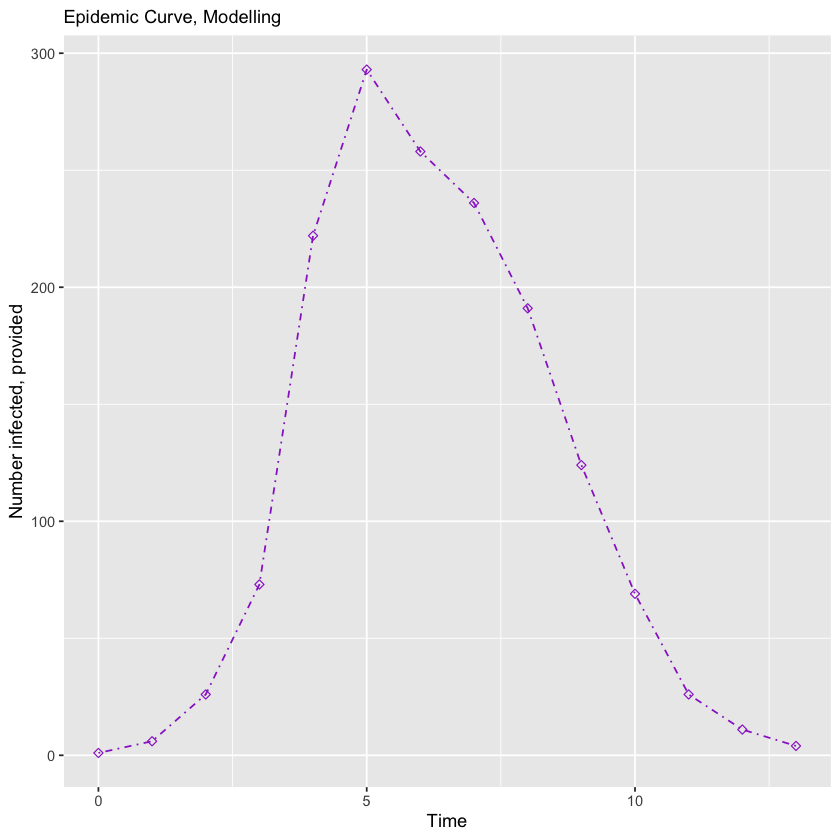

In [64]:


dataprov3 %>% 
  select(time, number_infected) %>% 
  ggplot(aes(x=time, y=number_infected)) +
  geom_line(linetype="dotdash", color="darkorchid") +
  geom_point(color="darkorchid", shape=5, show.legend = FALSE) +
  xlab("Time") +
  ylab("Number infected, provided") +
  labs(
    subtitle= "Epidemic Curve, Modelling") +
  theme(legend.position="bottom")

In [65]:
# SIR MODEL FUNCTION 
sir_model <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + R
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I)
      dR <- (gamma * I)
      return(list(c(dS, dI, dR)))
    })
}

# The sum-of-squares value (SSQ)  FUNCTION (assumes sir_model model already loaded)
# parameters - vector with named elements for sir_model
# idat - df or list containing vectors number_infected (I) and time
SIR_SSQv2 <- function(func, parameters, idat) {  
# MODEL OUTPUT (solving the differential equations):
oderesult <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = func,
                            parms = parameters))
# sum-of-squares (SSQ) of model fit requires idat
idat <- na.omit(idat)
deltas2 <- (oderesult$I[oderesult$time %in% idat$time] - idat$number_infected)^2
SSQ   <- sum(deltas2)
return(SSQ)
}

# initial_state_values and times
initial_state_values <- c(S = 499, I = 1, R = 0)
times <- seq(from = 0, to = 200, by = 1) 

# choose values to start your optimisation
beta_start  <- 0.9
gamma_start <- 0.1

# run optim
(optimised <- optim(par = c(beta = beta_start
                  , gamma = gamma_start)
                  , fn  = SIR_SSQv2
                  , func = sir_model
                  , idat = dataprov3
  ))

$par
     beta     gamma 
1.8818864 0.2946526 

$value
[1] 7791.828

$counts
function gradient 
      63       NA 

$convergence
[1] 0

$message
NULL

In [9]:
# examine optim() output and plot "best" model against example dataset
opt_mod <- as.data.frame(ode(y = initial_state_values  # named vector of initial state values
                  , times = times         # vector of times
                  , func = sir_model      # your predefined SIR function
                  , parms = optimised$par
  ))

nicesubtitle <- "Automated Least-Squares Calibration: Using optim() c2w3_3"

Joining, by = "time"


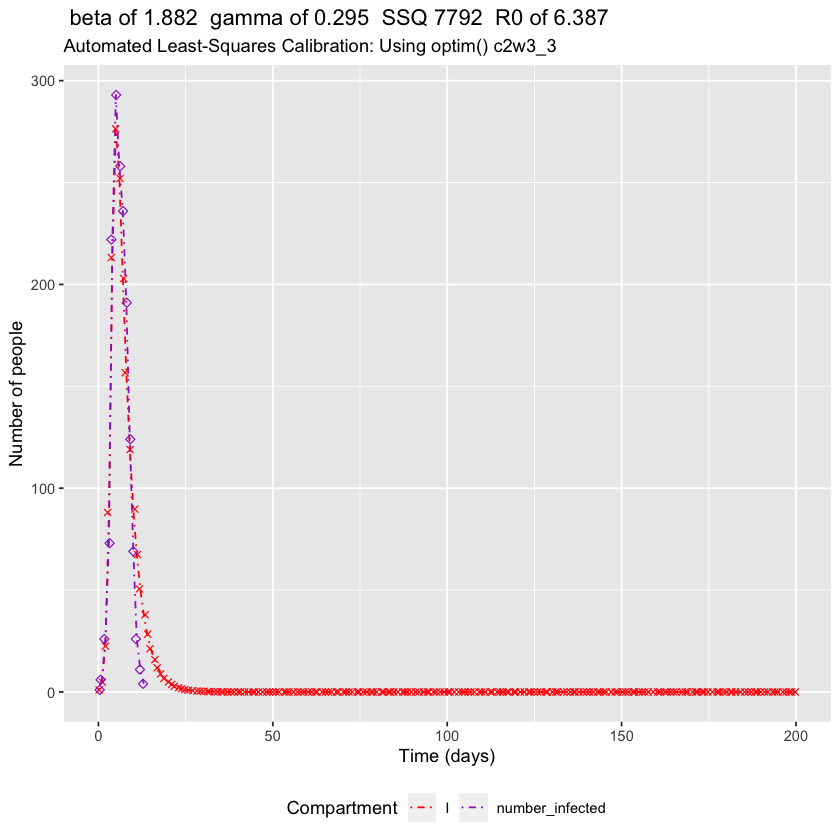

In [10]:
# Compare model I to infection numbers provided
opt_mod %>% 
  left_join(dataprov3) %>%
  select(time, I, number_infected) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("red","darkorchid")) + 
  scale_shape_manual(values = c(4,5)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", round(optimised$par[1],3),
    " gamma of", round(optimised$par[2],3),
    " SSQ", round(optimised$value,0),
    " R0 of", round(optimised$par[1]/optimised$par[2],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")  

Based on your estimates parameter values, what would be the critical vaccination threshold required to prevent this epidemic, assuming an all-or-nothing vaccine with 75% efficacy?
” …calculate the critical effective vaccination coverage as:
\begin{align}
p_{eff} & = 1-\frac{1}{R_0} \\
 & = 1-\frac{1}{\frac{\beta}{\gamma}} \\
 & = 1-\frac{0.295}{1.882} \\
 & = 0.8432
\end{align}

Since the all-or-nothing vaccine is only 75% effective, we can calculate the critical vaccination threshold as:
\begin{align}
p_{c} & = \frac{p_{eff}}{v_{eff}} \\
 & = \frac{ 0.8432}{0.75} \\
 & =8.506
\end{align}

To interrupt transmission and bring R0 above 1, 12% of the population would have to be vaccinated. ”

In [11]:
nicesubtitle <- "SIR Model v1a9 SIR Basic Model, check pvacc = pc of .92 \n all-or-nothing vaccine with 75% efficacy"


In [12]:
# MODEL INPUTS:
N        <- 500       # population size
duration <- 14       # total number of days
tsteps   <- 1         # chunk in days  
beta     <- 1.88188642103645       # infection rate day^-1
gamma    <- 0.29465259706606      # recovery rate day^-1
R0 <- beta / gamma


(parameters <- c(
  beta = beta,          # infection rate
  gamma = gamma,        # recovery rate for untreated I
  R0 = R0
  ))  

beta     gamma        R0 
1.8818864 0.2946526 6.3867973

In [13]:
1-(1/R0)

[1] 0.843427

In [14]:
0.843427002941134/.75

[1] 1.124569

In [15]:
# initial_state_values and times
initial_state_values <- c(S = (N-1) * .88, # 8% are susceptible
                          I = 1, 
                          R = (N-1) * .12) # 92% are vaccinated / immune
# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + R
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I)
      dR <- (gamma * I)
      return(list(c(dS, dI, dR)))
    })
}

# MODEL OUTPUT (solving the differential equations):
output2 <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + R),digits=5)*100,
    propor_Re = round(R/(S + I + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R)) ) 
  

In [16]:
print("peak infection day when I is at its max: ")
output2 %>%
  arrange(-I, time) %>%
  head(1)

[1] "peak infection day when I is at its max: "


,time,S,I,R,still_Su,preval_Inf,propor_Re,Reff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6,61.80897,224.8127,213.3783,12.362,44.963,42.676,0.7895227


In [17]:
print("point when R eff goes below 1: ")
output2 %>%
  filter(Reff < 1) %>% 
  arrange(time) %>%
  head(1)

[1] "point when R eff goes below 1: "


,time,S,I,R,still_Su,preval_Inf,propor_Re,Reff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6,61.80897,224.8127,213.3783,12.362,44.963,42.676,0.7895227


In [18]:
print("last record for the run: ")
output2 %>%
  arrange(time) %>%
  tail(1)

[1] "last record for the run: "


,time,S,I,R,still_Su,preval_Inf,propor_Re,Reff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15,14,2.413833,30.3382,467.248,0.483,6.068,93.45,0.03083333


[1] "Plotting the proportion of people in each compartment over time"


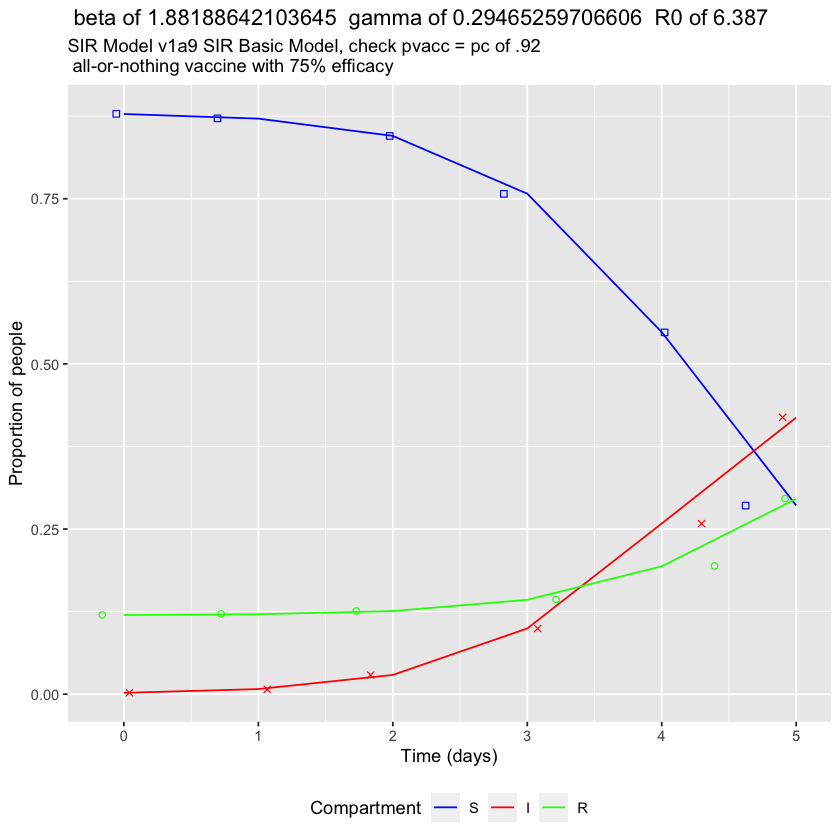

In [20]:
print("Plotting the proportion of people in each compartment over time")
## [1] "Plotting the proportion of people in each compartment over time"
output2 %>% 
  filter(time <= 5) %>% 
  select(-still_Su, -preval_Inf, -propor_Re, -Reff) %>% 
  melt(id = "time")  %>% 
  mutate(proportion = value / sum(initial_state_values)) %>% 
  ggplot(aes(x=time, y=proportion, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","green")) + 
  scale_shape_manual(values = c(0,4,1)) +
  xlab("Time (days)") +
  ylab("Proportion of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

[1] "Plotting the number of people in each compartment over time"


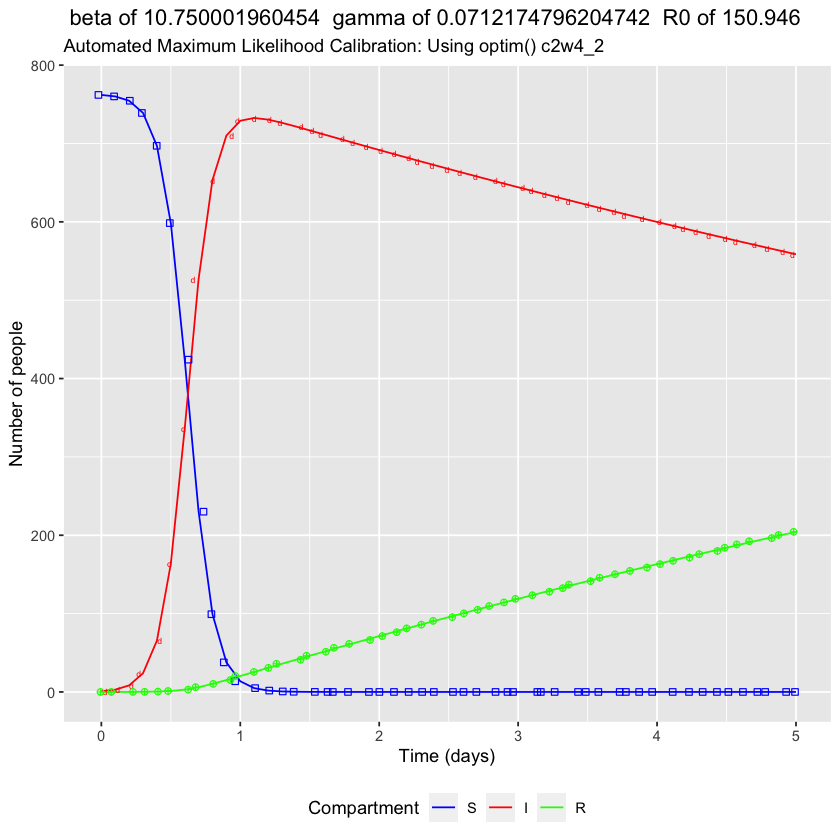

In [54]:
print("Plotting the number of people in each compartment over time")
output2 %>% 
  filter(time <= 5) %>% 
  select(-still_Su, -preval_Inf, -propor_Re, -Reff) %>% 
  melt(id = "time")  %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line() +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("blue","red","green")) + 
  scale_shape_manual(values = c(0,100,10)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom") 

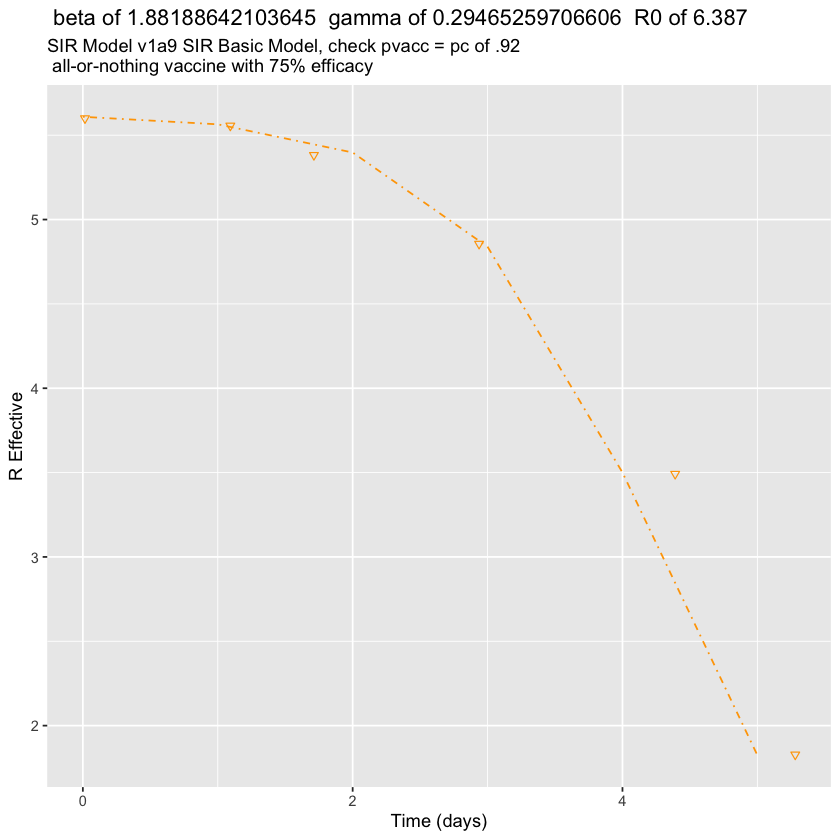

In [21]:
output2 %>% 
  filter(time <= 5) %>% 
  select(time, Reff) %>% 
  ggplot(aes(x=time, y=Reff)) +
  geom_line(linetype="dotdash", color="orange") +
  geom_jitter(color="orange", shape=6, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("R Effective") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3)),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

### Calibrating the SIR model using likelihood as a measure of the divergence
We are building up to calibrating the SIR model to our flu outbreak data using likelihood as a measure of the divergence between the model projections and the data.

Even though we are looking at the same outbreak, the dataset only shows the reported cases, and we know that 60% of flu cases are reported.

Load the model function, inputs and datasets. Plot of the dataset, then simulate the SIR model using the parameter values found in the prior manual calibration to the full dataset of the total number infected.

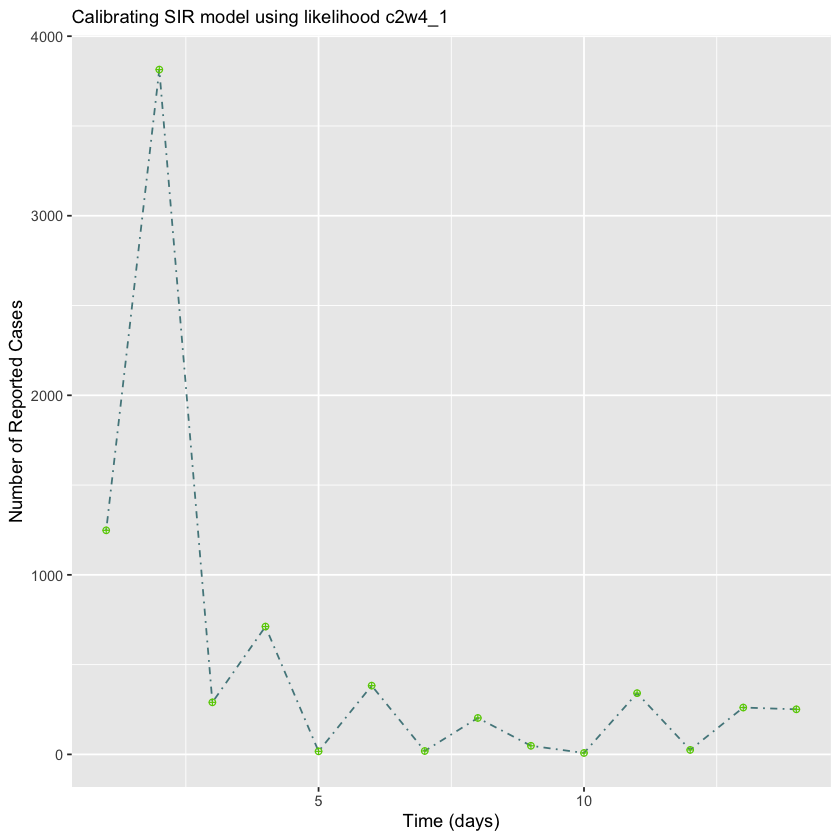

In [22]:
# 1 of 4
# Load the flu dataset of reported cases
dataprov4 <- read.csv("flu_data4.csv")

dataprov4 %>% 
  select(time,number_infected_c) %>% 
  ggplot(aes(x=time, y=number_infected_c)) +
  geom_line(linetype="dotdash", color="cadetblue4") +
  geom_point(color="chartreuse3", shape=10, show.legend = FALSE) +
  xlab("Time (days)") +
  ylab("Number of Reported Cases") +
  labs(
    subtitle= "Calibrating SIR model using likelihood c2w4_1") +
  theme(legend.position="bottom")

In [23]:
nicesubtitle <- "SIR Model v1a10 SIR Basic Model, reported data with provided beta and gamma c2w4_1"

In [24]:
print("initial state values and parameters")
# MODEL INPUTS:
N        <- 763      # population size
duration <- 14       # total number of days
tsteps   <- 0.1      # chunk in days  
beta     <- 1.7      # infection rate day^-1
gamma    <- 0.45     # recovery rate day^-1
R0 <- beta / gamma

(parameters <- c(
  beta = beta,          # infection rate
  gamma = gamma,        # recovery rate
  R0 = R0
  ))  

[1] "initial state values and parameters"


beta    gamma       R0 
1.700000 0.450000 3.777778

Joining, by = "time"


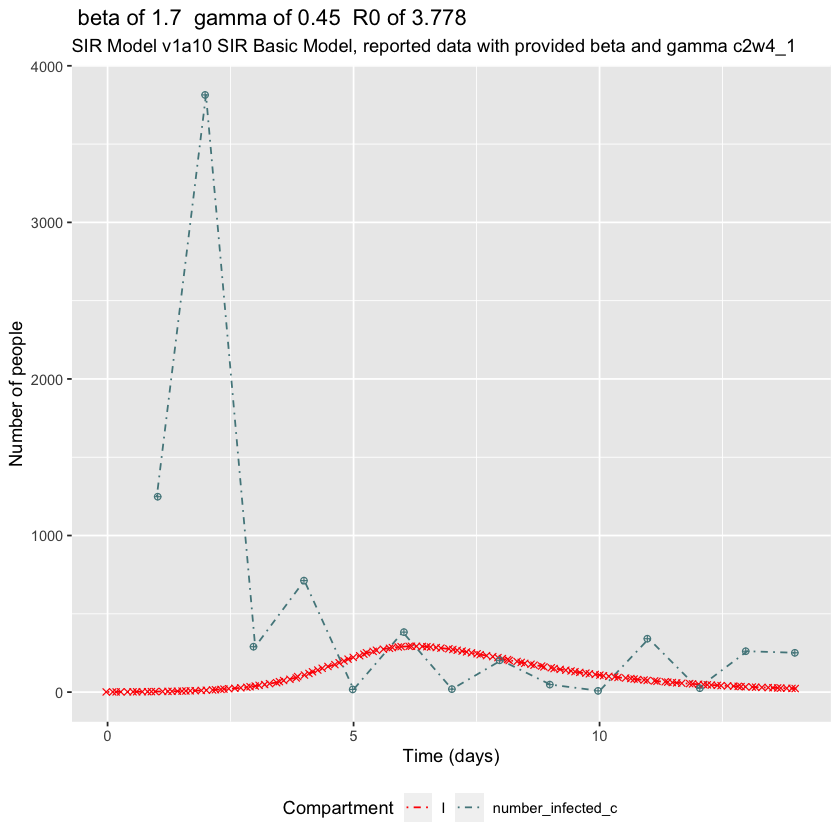

In [26]:
# initial_state_values and times
initial_state_values <- c(S = (N-1),
                          I = 1, 
                          R = 0)

# TIMESTEPS:
times <- seq(from = 0, to = duration, by = tsteps)

# SIR MODEL FUNCTION 
sir_model <- function(time, state, parameters) { 
    with(as.list(c(state, parameters)), {
      N <- S + I + R
      lambda <- beta * I/N
      dS <- -(lambda * S)
      dI <- (lambda * S) -(gamma * I)
      dR <- (gamma * I)
      return(list(c(dS, dI, dR)))
    })
}

# MODEL OUTPUT (solving the differential equations):
output2 <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + R),digits=5)*100,
    propor_Re = round(R/(S + I + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R)) ) 

output2 %>% 
  left_join(dataprov4) %>%
  select(time, I, number_infected_c) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("red","cadetblue4")) + 
  scale_shape_manual(values = c(4,10)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", parameters['beta'],
    " gamma of", parameters['gamma'],
    " R0 of", round(parameters['R0'],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")

We want to calculate the likelihood of the model with these specific parameter values, i.e. the probability of observing these numbers of reported cases given our simulated numbers of infected people.


### Poisson log-likelihood for the epidemic curve?

In [31]:
# Code block 4:
(LL <- sum(dpois(x =  dataprov4$number_infected_c, lambda = 0.6 * output2$I[output2$time %in%  dataprov4$time],
                 log = TRUE)))

[1] -30123.47

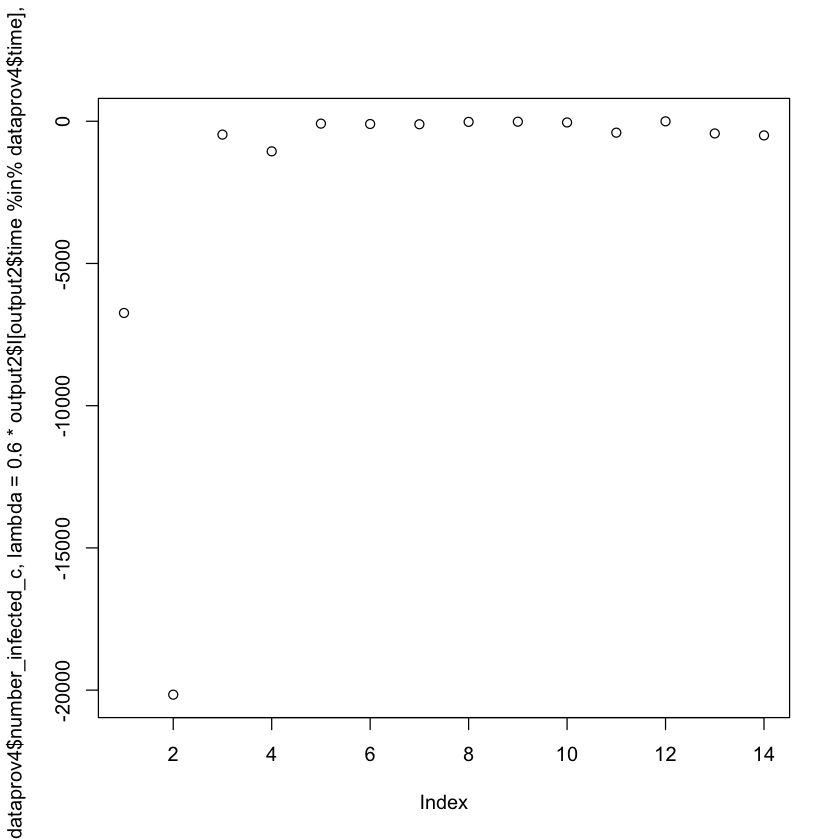

In [33]:
plot(dpois(x =  dataprov4$number_infected_c, lambda = 0.6 * output2$I[output2$time %in%  dataprov4$time], log = TRUE))

The dpois() command calculates the Poisson density - the Poisson distribution is a common choice to model the number of events (e.g. the number of reported infections) in a defined time interval.

For each timepoint, the dpois() command calculates the probability of observing the number of reported cases in the dataset (the x argument) given the number predicted by the model with the specified set of parameters (the lambda argument, not to be confused with the force of infection) – it calculates the likelihood of these parameter values for the given datapoint.

The dataset contains the number of reported cases at each timepoint, but the model simulates the total number of infections. To take this into account when calculating how close the simulation is to the observed data, we need to calculate the number of reported cases the model would predict with our knowledge of the reporting rate, i.e. we need to multiply the simulated total number of infections by 0.6.

We usually want to calculate the log-likelihood, not the likelihood itself. Accordingly, setting “log = TRUE” in dpois() calculates the log-Poisson density.

Finally, as we are working on the log-scale, calculating the overall likelihood for the whole epidemic curve requires summing the individual log-likelihoods using the sum() command.

### Performing maximum likelihood estimation
Use the code for calculating the Poisson log likelihood for a given parameter combination, together with the calibration function, to fit the model to our flu outbreak data – by finding the parameter values β and γ that maximise the likelihood. This will be calibrating the model using a likelihood approach.

Change your code to calculate the log-likelihood distance function instead of the sum-of-squares. The optimisation process is similar, except that we need to maximise the likelihood (versus minimise the distance as represented by sum of squares).

Define a function (the distance function described to in the lecture) that simulates the model for a given combination of parameters and calculates the Poisson log-likelihood for the epidemic curve of reported cases.



In [36]:
# 2 of 4
# DISTANCE FUNCTION
loglik_function <- function(parameters, idat) { # param  values and dataset
   beta <- parameters[1]  # first value in params is beta
   gamma <- parameters[2] # second value in params is gamma
    
# Simulate the model with initial conditions and timesteps
oderesult2 <- as.data.frame(ode(y = initial_state_values,
  times = times,
  func = sir_model,
  parms = c(beta = beta, # beta fr params of loglik_func
    gamma = gamma)))  # gamma from parameters of loglik_func
    
# Calculate log-likelihood, accounting for the reporting rate of 60%:
LL <- sum(dpois(x = idat$number_infected_c, lambda = 0.6 * oderesult2$I[oderesult2$time %in% idat$time], log = TRUE))
   return(LL) 
}

Optimise the function using the optim() command to find the values for beta and gamma giving the highest log-likelihood value as output:


In [37]:
# 3 of 4
# OPTIMISATION:
# optim(par = c(parameters['beta'],parameters['gamma']), # doesn't quite get exact same answer
# optim(par = c(1.7, 0.45),
# optim(par = c(1.0, 0.01),
(optimised2 <- optim(par = c(1.7, 0.1), # starting values for beta and gamma - you should get the same result no matter what but not true
      fn = loglik_function,
      idat = dataprov4,
      control = list(fnscale=-1))  # look for max
)

$par
[1] 10.75000196  0.07121748

$value
[1] -6763.387

$counts
function gradient 
      81       NA 

$convergence
[1] 0

$message
NULL

Since we have the full dataset of the number of infected people, confirm that these parameter values indeed produce a good visual fit to the real data by plotting the model simulation alongside the data, in the cell below.

In [40]:
nicesubtitle <- "Automated Maximum Likelihood Calibration: Using optim() c2w4_2"

Joining, by = "time"


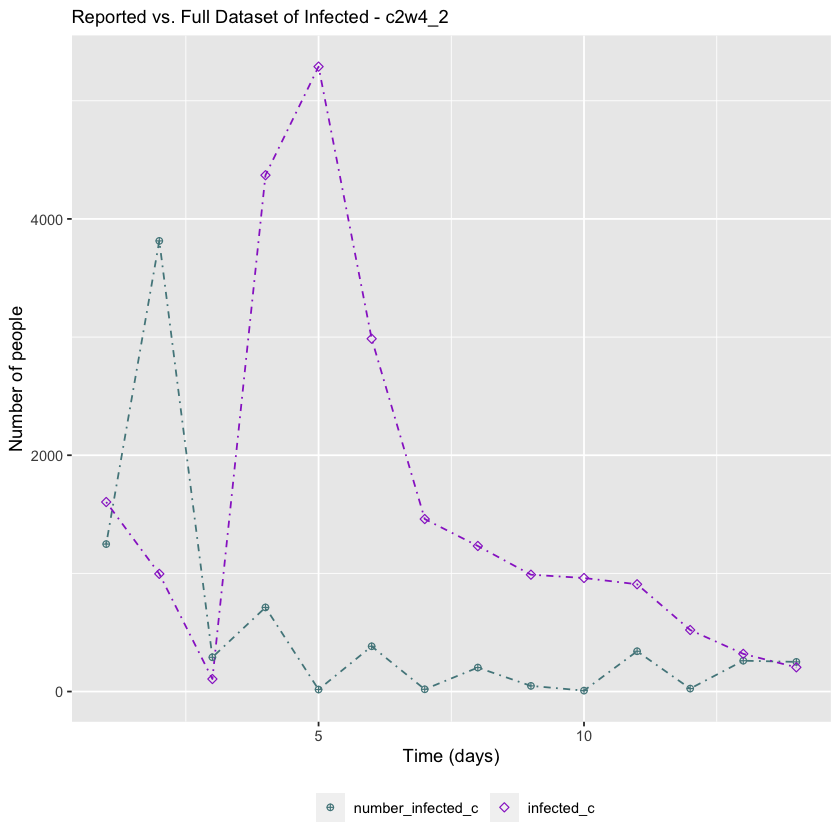

In [41]:
# Load the flu dataset of the total number infected
dataprov5 <- read.csv("flu_data5.csv")

# plot total number infected versus prior reported infected
dataprov5 %>% 
  left_join(dataprov4) %>%
  select(time, number_infected_c, infected_c) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash",show.legend = FALSE) +
  geom_point() +
  scale_color_manual(values = c("cadetblue4","darkorchid")) + 
  scale_shape_manual(values = c(10,5)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(subtitle= "Reported vs. Full Dataset of Infected - c2w4_2") +
  theme(legend.position="bottom") + 
  theme(legend.title = element_blank())

In [42]:
# simulate model with the best-fitting (max-likelihood) parameters from prior steps
(parameters <- c(beta = optimised2$par[1],
  gamma = optimised2$par[2],
  R0 = optimised2$par[1]/optimised2$par[2]
  ))

beta        gamma           R0 
 10.75000196   0.07121748 150.94611629

Joining, by = "time"
Joining, by = "time"


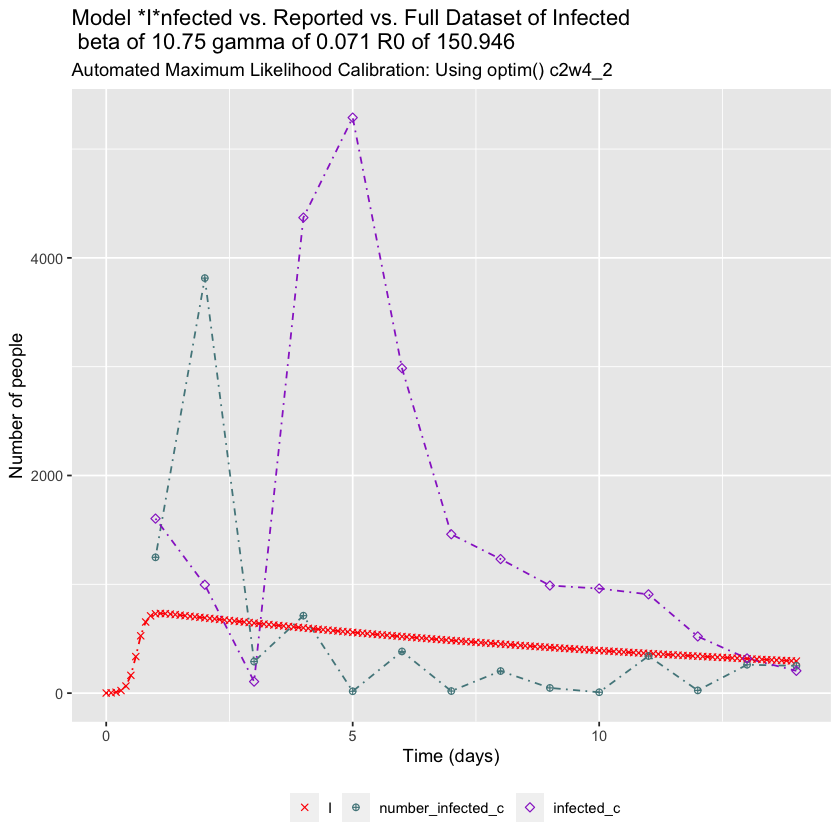

In [44]:
# MODEL OUTPUT (solving the differential equations):
output2 <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + R),digits=5)*100,
    propor_Re = round(R/(S + I + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R)) ) 

output2 %>% 
  left_join(dataprov5) %>%
  left_join(dataprov4) %>%
  select(time, I, number_infected_c,infected_c) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash",show.legend = FALSE) +
  geom_point() +
  scale_color_manual(values = c("red", "cadetblue4", "darkorchid")) + 
  scale_shape_manual(values = c(4, 10, 5)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title= paste0("Model *I*nfected vs. Reported vs. Full Dataset of Infected",
    "\n beta of ", round(parameters['beta'],3),
    " gamma of ", round(parameters['gamma'],3),
    " R0 of ", round(parameters['R0'],3)),
    subtitle= nicesubtitle) +
  theme(legend.position="bottom") + 
  theme(legend.title = element_blank())  

Joining, by = "time"
Joining, by = "time"


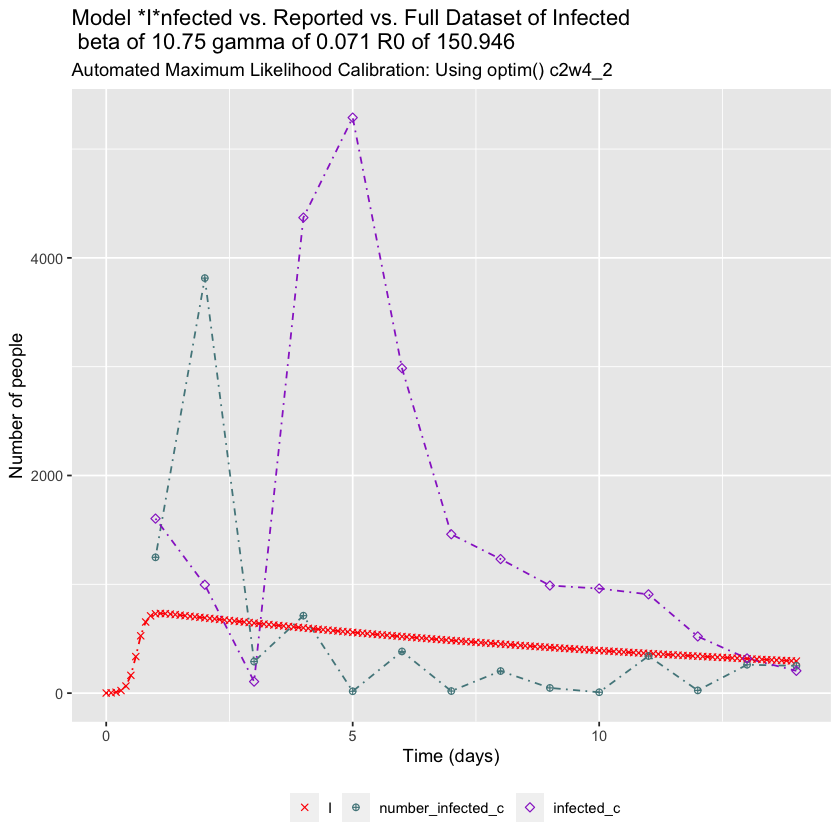

In [51]:
# MODEL OUTPUT (solving the differential equations):
output2 <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sir_model,
                            parms = parameters)) %>% 
  mutate(still_Su = round(S/(S + I + R),digits=5)*100,
    preval_Inf = round(I/(S+ I + R),digits=5)*100,
    propor_Re = round(R/(S + I + R),digits=5)*100,
    Reff = (parameters['beta']/parameters['gamma']) 
    * (S/(S + I + R)) ) 

output2 %>% 
  left_join(dataprov5) %>%
  left_join(dataprov4) %>%
  select(time, I, number_infected_c, infected_c) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash",show.legend = FALSE) +
  geom_point() +
  scale_color_manual(values = c("red", "cadetblue4", "darkorchid")) + 
  scale_shape_manual(values = c(4, 10, 5)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title= paste0("Model *I*nfected vs. Reported vs. Full Dataset of Infected",
    "\n beta of ", round(parameters['beta'],3),
    " gamma of ", round(parameters['gamma'],3),
    " R0 of ", round(parameters['R0'],3)),
    subtitle= nicesubtitle) +
  theme(legend.position="bottom") + 
  theme(legend.title = element_blank())  

Joining, by = "time"


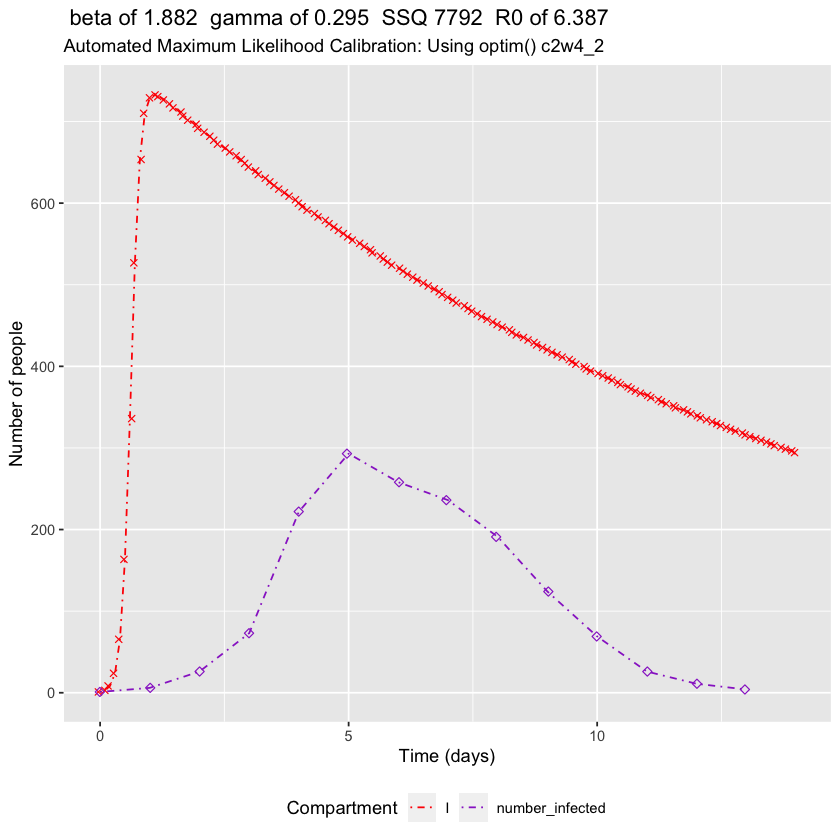

In [46]:
# Compare model I to infection numbers provided
output2 %>% 
  left_join(dataprov3) %>%
  select(time, I, number_infected) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("red","darkorchid")) + 
  scale_shape_manual(values = c(4,5)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", round(optimised$par[1],3),
    " gamma of", round(optimised$par[2],3),
    " SSQ", round(optimised$value,0),
    " R0 of", round(optimised$par[1]/optimised$par[2],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")  

Joining, by = "time"


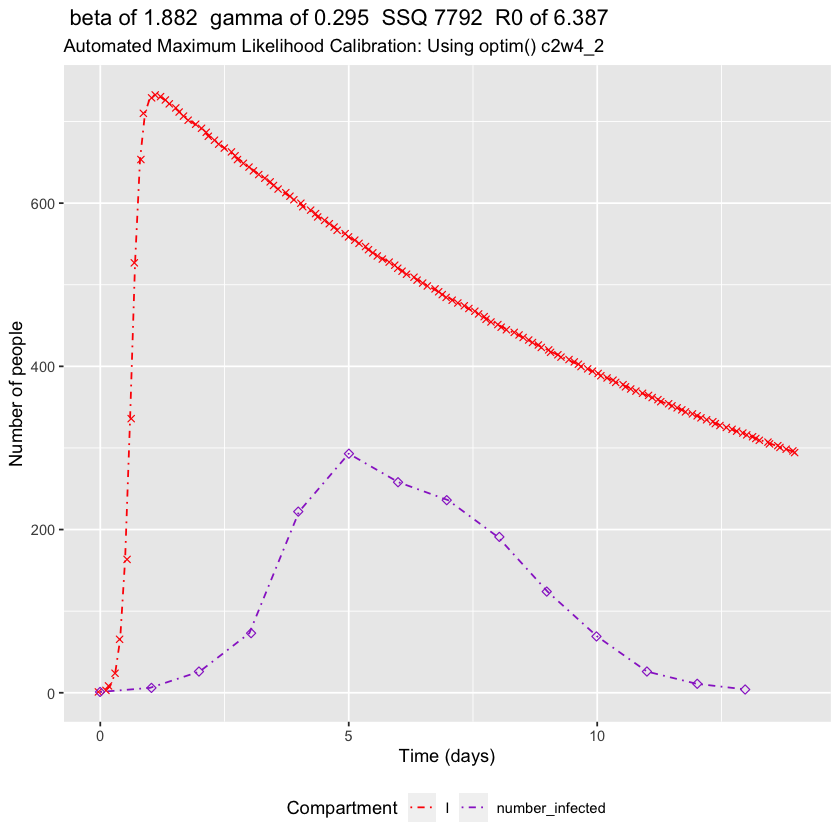

In [49]:
# Compare model I to infection numbers provided
output2 %>% 
  left_join(dataprov3) %>%
  select(time, I, number_infected) %>% 
  melt(id = "time") %>%
  filter(!is.na(value)) %>% 
  ggplot(aes(x=time, y=value, color=variable, shape=variable)) +
  geom_line(linetype="dotdash") +
  geom_jitter(show.legend = FALSE) +
  scale_color_manual(values = c("red","darkorchid")) + 
  scale_shape_manual(values = c(4,5)) +
  xlab("Time (days)") +
  ylab("Number of people") +
  labs(title=paste(" beta of", round(optimised$par[1],3),
    " gamma of", round(optimised$par[2],3),
    " SSQ", round(optimised$value,0),
    " R0 of", round(optimised$par[1]/optimised$par[2],3)
    ),
    color = "Compartment",
    subtitle= nicesubtitle) +
  theme(legend.position="bottom")  